<a href="https://colab.research.google.com/github/KenzaxTazi/Agri-Risk/blob/master/RFECV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os, sys
path = '/content/drive/My Drive/GTC'
os.chdir(path)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time
%matplotlib inline

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

## Import seasonal datasets

In [21]:
seasonal_df = pd.read_csv("WORLD_['maiz']_['CDD', 'CWD', 'CFD', 'CSDI', 'WSDI', 'WW']_2010_2005_climate_zones_onehot.csv")
seasonal_features_df = seasonal_df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1'],
                                        axis=1)
seasonal_features_df

,iso3_2005,x,y,maiz_a_2005,maiz_a_2010,delta_maiz,maiz_percent_change,CDD-Q1_2005,CDD-Q1_2010,CDD-Q2_2005,CDD-Q2_2010,CDD-Q3_2005,CDD-Q3_2010,CDD-Q4_2005,CDD-Q4_2010,CWD-Q1_2005,CWD-Q1_2010,CWD-Q2_2005,CWD-Q2_2010,CWD-Q3_2005,CWD-Q3_2010,CWD-Q4_2005,CWD-Q4_2010,CFD-Q1_2005,CFD-Q1_2010,CFD-Q2_2005,CFD-Q2_2010,CFD-Q3_2005,CFD-Q3_2010,CFD-Q4_2005,CFD-Q4_2010,CSDI-Q1_2005,CSDI-Q1_2010,CSDI-Q2_2005,CSDI-Q2_2010,CSDI-Q3_2005,CSDI-Q3_2010,CSDI-Q4_2005,CSDI-Q4_2010,WSDI-Q1_2005,WSDI-Q1_2010,WSDI-Q2_2005,WSDI-Q2_2010,WSDI-Q3_2005,WSDI-Q3_2010,WSDI-Q4_2005,WSDI-Q4_2010,WW-Q1_2005,WW-Q1_2010,WW-Q2_2005,WW-Q2_2010,WW-Q3_2005,WW-Q3_2010,WW-Q4_2005,WW-Q4_2010,climate_zone,soil_type,Inland water bodies,Subtropics - summer rainfall,Subtropics - winter rainfall,Temperature - continental,Temperature - oceanic,Temperature - subcontinental,Tropics
0,CIV,-3.208,5.208,2292.2,2867.5,575.3,0.250982,24.0,31.0,3.0,2.0,6.0,6.0,2.0,1.0,10.0,21.0,30.0,26.0,25.0,27.0,65.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2.0,24.0,1.0,11.0,13.0,16.0,Inland water bodies,4.0,1,0,0,0,0,0,0
1,USA,-76.042,35.958,6665.7,6052.0,-613.7,-0.092068,18.0,8.0,7.0,11.0,11.0,6.0,12.0,11.0,5.0,4.0,5.0,5.0,11.0,6.0,9.0,6.0,9.0,15.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,2.0,0.0,3.0,3.0,4.0,Inland water bodies,2.0,1,0,0,0,0,0,0
2,USA,-76.292,35.958,7071.2,6420.1,-651.1,-0.092078,18.0,8.0,7.0,11.0,11.0,6.0,12.0,11.0,5.0,4.0,5.0,5.0,11.0,6.0,9.0,6.0,9.0,15.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,2.0,0.0,3.0,3.0,4.0,Inland water bodies,2.0,1,0,0,0,0,0,0
3,USA,-76.458,35.958,7471.4,6671.0,-800.4,-0.107129,18.0,8.0,7.0,11.0,11.0,6.0,12.0,11.0,5.0,4.0,5.0,5.0,11.0,6.0,9.0,6.0,9.0,15.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,2.0,0.0,3.0,3.0,4.0,Inland water bodies,2.0,1,0,0,0,0,0,0
4,CHN,116.042,29.792,8656.9,7956.7,-700.2,-0.080883,17.0,11.0,11.0,8.0,8.0,6.0,22.0,21.0,6.0,4.0,7.0,7.0,10.0,14.0,8.0,5.0,9.0,6.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,8.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,3.0,4.0,0.0,0.0,5.0,0.0,Inland water bodies,1.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307857,RUS,61.375,54.625,2170.3,2179.6,9.3,0.004285,30.0,17.0,11.0,22.0,11.0,11.0,29.0,35.0,4.0,4.0,2.0,3.0,7.0,5.0,4.0,2.0,90.0,90.0,37.0,48.0,0.0,0.0,22.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,Temperature - continental,18.0,0,0,0,1,0,0,0
307858,RUS,61.458,54.625,2062.6,2071.4,8.8,0.004266,30.0,17.0,11.0,22.0,11.0,11.0,29.0,35.0,4.0,4.0,2.0,3.0,7.0,5.0,4.0,2.0,90.0,90.0,37.0,48.0,0.0,0.0,22.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,Temperature - continental,18.0,0,0,0,1,0,0,0
307859,CHN,123.542,43.792,5086.2,4958.5,-127.7,-0.025107,39.0,29.0,38.0,10.0,11.0,13.0,25.0,26.0,2.0,1.0,2.0,4.0,12.0,8.0,4.0,3.0,90.0,90.0,19.0,29.0,0.0,0.0,26.0,11.0,6.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,3.0,0.0,Temperature - continental,33.0,0,0,0,1,0,0,0
307860,CHN,123.042,53.292,2819.2,3918.1,1098.9,0.389791,27.0,27.0,49.0,29.0,8.0,9.0,14.0,16.0,2.0,3.0,2.0,5.0,7.0,4.0,3.0,4.0,90.0,90.0,65.0,61.0,1.0,1.0,61.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,1.0,1.0,Boreal - continental,40.0,0,0,0,0,0,0,0


# Cross-validated RFE

In [0]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn import feature_selection
from sklearn.model_selection import KFold
import time

In [0]:
pipe = Pipeline(
    [
        ('std_scaler', preprocessing.StandardScaler()),
        ("RF", RandomForestRegressor(random_state=42, n_estimators=500,n_jobs=-1))
    ]
)

In [0]:
class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

## RFECV with all features

In [0]:
seasonal_features_df.dropna(inplace=True)
X=seasonal_features_df.drop(['maiz_a_2010'], axis=1).drop(['iso3_2005','climate_zone'], axis=1)[0:1000]
y = seasonal_features_df['maiz_a_2010'][0:1000]

In [0]:
feature_names = seasonal_features_df.drop(['maiz_a_2010'], axis=1).drop(['iso3_2005','climate_zone'], axis=1).columns

In [27]:
start = time.time()
pipe = PipelineRFE(
    [
        ('std_scaler', preprocessing.StandardScaler()),
        ("RF", RandomForestRegressor(random_state=42, n_estimators=500, n_jobs=-1))
    ]
)

_ = KFold(random_state=42, shuffle=True)

feature_selector_cv = feature_selection.RFECV(pipe, cv=10, step=1, scoring="neg_mean_squared_error")
feature_selector_cv.fit(X, y)
stop=time.time()
print(f"training time: {stop-start}s")
print(f"number of features: {feature_selector_cv.n_features_}")

KeyboardInterrupt: ignored

In [0]:
cv_grid_rmse = np.sqrt(-feature_selector_cv.grid_scores_)
cv_grid_rmse

array([927.3954993 , 178.40897842, 171.3153828 , 199.484713  ,
       219.69910984, 219.36942069, 228.13409   , 233.87591546,
       242.60836028, 246.24510156, 250.77720494, 255.32063602,
       256.84328934, 260.29052387, 260.29292021, 263.04508926,
       262.38933413, 263.776399  , 264.26851742, 266.38060068,
       270.0829583 , 269.86706671, 270.87999527, 273.56225211,
       272.24585656, 274.74509506, 274.60749507, 276.00397354,
       275.29385233, 276.17314685, 276.41078926, 278.95898463,
       278.30918252, 277.73460984, 278.04126714, 277.95808795,
       277.26982675, 278.9287252 , 279.84119049, 279.67149379,
       279.02159634, 279.73583899, 279.73508463, 279.67086539,
       278.661138  , 279.6924242 , 279.70000751, 277.82533205,
       278.76544123, 278.84648159, 281.27486947, 280.40287956,
       277.83395868, 280.37336771, 281.35110069, 280.71770764,
       281.1472887 , 280.8451988 , 279.28489099, 280.61069665,
       280.59031294])

In [0]:
selected_features = feature_names[feature_selector_cv.support_].tolist()
selected_features

['maiz_a_2005', 'delta_maiz', 'maiz_percent_change']

## RFECV, removing yield information

In [0]:
seasonal_features_df.dropna(inplace=True)
X=seasonal_features_df.drop(['maiz_a_2010'], axis=1).drop(['iso3_2005','climate_zone', 'maiz_a_2005', 'delta_maiz', 'maiz_percent_change'], axis=1)[0:1000]
y = seasonal_features_df['maiz_a_2010'][0:1000]

In [0]:
start = time.time()
pipe = PipelineRFE(
    [
        ('std_scaler', preprocessing.StandardScaler()),
        ("RF", RandomForestRegressor(random_state=42, n_estimators=500, n_jobs=-1))
    ]
)

_ = KFold(random_state=42, shuffle=True)

feature_selector_cv = feature_selection.RFECV(pipe, cv=10, step=1, scoring="neg_mean_squared_error")
feature_selector_cv.fit(X, y)
stop=time.time()
print(f"training time: {stop-start}s")
print(f"number of features: {feature_selector_cv.n_features_}")

NameError: ignored

In [0]:
cv_grid_rmse = np.sqrt(-feature_selector_cv.grid_scores_)
cv_grid_rmse

array([2370.72799307, 1668.04342313, 1673.45354373, 1745.89262393,
       1758.70258827, 1787.64891709, 1758.10546898, 1747.51675512,
       1723.70095387, 1728.86310374, 1725.30115112, 1732.09027203,
       1739.60427514, 1737.51920768, 1739.91369244, 1746.40637989,
       1750.46719657, 1751.54961723, 1746.14889407, 1748.44155994,
       1751.14844323, 1756.21733428, 1751.11096247, 1756.99685507,
       1753.20828456, 1750.0329302 , 1754.94702434, 1757.36473586,
       1755.88424432, 1754.29403893, 1755.21199475, 1749.53758421,
       1754.28468176, 1749.4601014 , 1750.64189976, 1741.82240727,
       1740.01682112, 1748.71144411, 1743.93908239, 1738.42858129,
       1734.18163703, 1740.54234784, 1737.91705828, 1740.83263779,
       1739.7752306 , 1738.97655365, 1739.39707024, 1740.30442411,
       1740.46485824, 1739.32527225, 1741.01619359, 1741.05905609,
       1740.71611279, 1740.06979973, 1739.07576649, 1736.7394806 ,
       1738.52090493, 1740.85135807])

In [0]:
feature_names=seasonal_features_df.drop(['maiz_a_2010'], axis=1).drop(['iso3_2005','climate_zone', 'maiz_a_2005', 'delta_maiz', 'maiz_percent_change'], axis=1).columns

selected_features = feature_names[feature_selector_cv.support_].tolist()
selected_features

['x', 'y']

## RFECV, removing x, y coordinatees

In [0]:
# try also dropping x and y
seasonal_features_df.dropna(inplace=True)
X=seasonal_features_df.drop(['maiz_a_2010'], axis=1).drop(['iso3_2005','climate_zone', 'maiz_a_2005', 'delta_maiz', 'maiz_percent_change','x','y'], axis=1)[0:1000]
y = seasonal_features_df['maiz_a_2010'][0:1000]

In [0]:
start = time.time()
pipe = PipelineRFE(
    [
        ('std_scaler', preprocessing.StandardScaler()),
        ("RF", RandomForestRegressor(random_state=42, n_estimators=500, n_jobs=-1))
    ]
)

_ = KFold(random_state=42, shuffle=True)

feature_selector_cv = feature_selection.RFECV(pipe, cv=10, step=1, scoring="neg_mean_squared_error")
feature_selector_cv.fit(X, y)
stop=time.time()
print(f"training time: {stop-start}s")
print(f"number of features: {feature_selector_cv.n_features_}")

training time: 1902.294221162796s
number of features: 51


In [0]:
cv_grid_rmse = np.sqrt(-feature_selector_cv.grid_scores_)
cv_grid_rmse

array([2252.57783273, 2269.99347577, 2145.1441323 , 2087.60780325,
       2009.98117958, 1973.05451787, 1933.01814516, 1901.19163399,
       1870.21886283, 1862.09409061, 1841.45300395, 1824.93159154,
       1833.98486045, 1842.09169656, 1844.04876613, 1838.49400026,
       1843.12892735, 1848.67896682, 1843.81418175, 1850.51372166,
       1846.96998624, 1837.30349677, 1839.7618289 , 1830.14425087,
       1827.45490273, 1826.79488478, 1827.6977965 , 1835.5070222 ,
       1838.17837714, 1839.97130784, 1831.85796611, 1837.09031866,
       1834.71352124, 1835.91345903, 1835.46059723, 1826.68918208,
       1821.68398801, 1829.38498416, 1826.17216871, 1825.46052684,
       1822.9244505 , 1821.21585876, 1822.6403314 , 1827.27107531,
       1823.79948741, 1821.30627648, 1824.21391339, 1823.50088292,
       1823.15870864, 1821.16221691, 1818.96876219, 1820.29895493,
       1822.37833235, 1822.00399059, 1822.66445723, 1823.14948045])

In [0]:
feature_names=seasonal_features_df.drop(['maiz_a_2010'], axis=1).drop(['iso3_2005','climate_zone', 'maiz_a_2005', 'delta_maiz', 'maiz_percent_change', 'x', 'y'], axis=1).columns

selected_features = feature_names[feature_selector_cv.support_].tolist()
selected_features

['CDD-Q1_2005',
 'CDD-Q1_2010',
 'CDD-Q2_2005',
 'CDD-Q2_2010',
 'CDD-Q3_2005',
 'CDD-Q3_2010',
 'CDD-Q4_2005',
 'CDD-Q4_2010',
 'CWD-Q1_2005',
 'CWD-Q1_2010',
 'CWD-Q2_2005',
 'CWD-Q2_2010',
 'CWD-Q3_2005',
 'CWD-Q3_2010',
 'CWD-Q4_2005',
 'CWD-Q4_2010',
 'CFD-Q1_2005',
 'CFD-Q1_2010',
 'CFD-Q2_2005',
 'CFD-Q2_2010',
 'CFD-Q3_2005',
 'CFD-Q3_2010',
 'CFD-Q4_2005',
 'CFD-Q4_2010',
 'CSDI-Q1_2005',
 'CSDI-Q1_2010',
 'CSDI-Q2_2005',
 'CSDI-Q2_2010',
 'CSDI-Q3_2005',
 'CSDI-Q3_2010',
 'CSDI-Q4_2005',
 'CSDI-Q4_2010',
 'WSDI-Q1_2005',
 'WSDI-Q1_2010',
 'WSDI-Q2_2005',
 'WSDI-Q2_2010',
 'WSDI-Q3_2005',
 'WSDI-Q3_2010',
 'WSDI-Q4_2005',
 'WSDI-Q4_2010',
 'WW-Q1_2005',
 'WW-Q1_2010',
 'WW-Q2_2005',
 'WW-Q2_2010',
 'WW-Q3_2005',
 'WW-Q3_2010',
 'WW-Q4_2005',
 'WW-Q4_2010',
 'soil_type',
 'Inland water bodies',
 'Subtropics - summer rainfall']

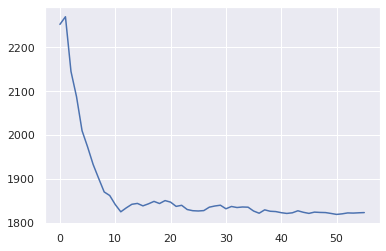

In [0]:
plt.plot(cv_grid_rmse)

# Import 10-day feature datasets

In [28]:
ten_day_df = pd.read_csv('head_of_soils_recommendations.csv')
ten_day_df

,Unnamed: 0,alloc_key,lon,lat,iso3,maize_a_2010,maize_a_2005,BEDD-01-05-2010,BEDD-02-05-2010,BEDD-03-05-2010,BEDD-04-05-2010,BEDD-05-05-2010,BEDD-06-05-2010,BEDD-07-05-2010,BEDD-08-05-2010,BEDD-09-05-2010,BEDD-10-05-2010,BEDD-11-05-2010,BEDD-12-05-2010,BEDD-01-15-2010,BEDD-02-15-2010,BEDD-03-15-2010,BEDD-04-15-2010,BEDD-05-15-2010,BEDD-06-15-2010,BEDD-07-15-2010,BEDD-08-15-2010,BEDD-09-15-2010,BEDD-10-15-2010,BEDD-11-15-2010,BEDD-12-15-2010,BEDD-01-25-2010,BEDD-02-25-2010,BEDD-03-25-2010,BEDD-04-25-2010,BEDD-05-25-2010,BEDD-06-25-2010,BEDD-07-25-2010,BEDD-08-25-2010,BEDD-09-25-2010,...,DTR-09-25-2010,DTR-10-25-2010,DTR-11-25-2010,DTR-12-25-2010,DTR-01-05-2005,DTR-02-05-2005,DTR-03-05-2005,DTR-04-05-2005,DTR-05-05-2005,DTR-06-05-2005,DTR-07-05-2005,DTR-08-05-2005,DTR-09-05-2005,DTR-10-05-2005,DTR-11-05-2005,DTR-12-05-2005,DTR-01-15-2005,DTR-02-15-2005,DTR-03-15-2005,DTR-04-15-2005,DTR-05-15-2005,DTR-06-15-2005,DTR-07-15-2005,DTR-08-15-2005,DTR-09-15-2005,DTR-10-15-2005,DTR-11-15-2005,DTR-12-15-2005,DTR-01-25-2005,DTR-02-25-2005,DTR-03-25-2005,DTR-04-25-2005,DTR-05-25-2005,DTR-06-25-2005,DTR-07-25-2005,DTR-08-25-2005,DTR-09-25-2005,DTR-10-25-2005,DTR-11-25-2005,DTR-12-25-2005
0,0,4383640,123.291667,53.541667,CHN,3918.1,2819.2,0.000000,0.000000,0.000000,0.000000,0.000000,41.363127,58.864516,37.987717,35.519341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.397859,35.972803,70.771844,47.295640,13.864582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.759598,117.686572,78.207775,51.866659,0.000000,...,11.727703,13.787956,9.926498,11.371226,12.503196,12.908701,16.032727,13.402978,11.735192,16.610372,9.410874,15.312115,13.542417,16.038854,9.848100,12.936875,15.138467,19.237968,18.427092,11.584098,15.175377,14.674588,14.688044,15.483794,11.441020,11.420742,15.016444,10.487718,13.816922,18.504860,18.507736,15.031678,17.593290,15.704611,18.523022,14.092479,15.016566,13.988310,18.100036,12.329345
1,2,4393629,122.375000,53.458333,CHN,3119.3,2028.5,0.000000,0.000000,0.000000,0.000000,0.000000,46.733022,67.613537,43.898331,36.698276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.459904,39.495712,78.767241,52.374707,14.427820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.772268,125.595174,83.146588,55.973652,0.000000,...,11.912833,13.628348,11.160431,11.007959,12.945838,12.618908,17.508302,13.575372,12.651447,16.761110,9.316199,15.640966,14.423927,16.998112,9.292246,12.221441,14.103506,20.599868,19.241434,12.576798,15.924542,14.954824,14.986558,15.608261,12.051438,11.944841,14.345663,10.443484,13.584308,18.917152,18.651182,15.191576,16.881676,16.390320,18.770228,14.457341,15.568386,14.757354,18.749596,12.080565
2,7,4403648,123.958333,53.375000,CHN,3230.1,2337.9,0.000000,0.000000,0.000000,0.000000,0.000000,42.146906,58.197767,38.470460,36.390766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.700476,37.185835,69.226086,48.036306,16.367400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.950559,116.095221,79.417204,53.371251,0.000000,...,11.412658,13.940518,9.111539,11.555232,12.414833,13.285697,15.601179,13.165404,10.974052,16.134251,9.555662,14.871300,12.659969,15.561574,10.324795,13.343145,14.664218,18.112774,17.477607,11.057737,14.727950,14.167884,14.187781,15.036729,11.477290,11.496888,15.057879,11.031311,14.502568,18.348780,18.019471,14.658110,18.091173,15.529109,18.057473,14.120732,14.818996,13.382273,17.323588,12.099928
3,8,4403649,124.041667,53.375000,CHN,3119.3,2010.2,0.000000,0.000000,0.000000,0.000000,0.000000,42.653685,58.725946,39.027351,36.776440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.783617,37.781733,69.630878,48.656871,16.629891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.459567,116.369432,80.279322,54.095035,0.000000,...,11.393748,13.889010,8.999466,11.520067,12.391664,13.244279,15.525052,13.112559,10.872659,16.008852,9.590657,14.801929,12.553973,15.462869,10.335471,13

In [29]:
cols = ten_day_df.columns.tolist()
cols

['Unnamed: 0',
 'alloc_key',
 'lon',
 'lat',
 'iso3',
 'maize_a_2010',
 'maize_a_2005',
 'BEDD-01-05-2010',
 'BEDD-02-05-2010',
 'BEDD-03-05-2010',
 'BEDD-04-05-2010',
 'BEDD-05-05-2010',
 'BEDD-06-05-2010',
 'BEDD-07-05-2010',
 'BEDD-08-05-2010',
 'BEDD-09-05-2010',
 'BEDD-10-05-2010',
 'BEDD-11-05-2010',
 'BEDD-12-05-2010',
 'BEDD-01-15-2010',
 'BEDD-02-15-2010',
 'BEDD-03-15-2010',
 'BEDD-04-15-2010',
 'BEDD-05-15-2010',
 'BEDD-06-15-2010',
 'BEDD-07-15-2010',
 'BEDD-08-15-2010',
 'BEDD-09-15-2010',
 'BEDD-10-15-2010',
 'BEDD-11-15-2010',
 'BEDD-12-15-2010',
 'BEDD-01-25-2010',
 'BEDD-02-25-2010',
 'BEDD-03-25-2010',
 'BEDD-04-25-2010',
 'BEDD-05-25-2010',
 'BEDD-06-25-2010',
 'BEDD-07-25-2010',
 'BEDD-08-25-2010',
 'BEDD-09-25-2010',
 'BEDD-10-25-2010',
 'BEDD-11-25-2010',
 'BEDD-12-25-2010',
 'BEDD-01-05-2005',
 'BEDD-02-05-2005',
 'BEDD-03-05-2005',
 'BEDD-04-05-2005',
 'BEDD-05-05-2005',
 'BEDD-06-05-2005',
 'BEDD-07-05-2005',
 'BEDD-08-05-2005',
 'BEDD-09-05-2005',
 'BEDD-10-05

In [0]:
ten_day_features_df = ten_day_df.drop(['Unnamed: 0', 'alloc_key', 'alloc_key', 'iso3'], axis=1)

In [31]:
ten_day_features_df

,lon,lat,maize_a_2010,maize_a_2005,BEDD-01-05-2010,BEDD-02-05-2010,BEDD-03-05-2010,BEDD-04-05-2010,BEDD-05-05-2010,BEDD-06-05-2010,BEDD-07-05-2010,BEDD-08-05-2010,BEDD-09-05-2010,BEDD-10-05-2010,BEDD-11-05-2010,BEDD-12-05-2010,BEDD-01-15-2010,BEDD-02-15-2010,BEDD-03-15-2010,BEDD-04-15-2010,BEDD-05-15-2010,BEDD-06-15-2010,BEDD-07-15-2010,BEDD-08-15-2010,BEDD-09-15-2010,BEDD-10-15-2010,BEDD-11-15-2010,BEDD-12-15-2010,BEDD-01-25-2010,BEDD-02-25-2010,BEDD-03-25-2010,BEDD-04-25-2010,BEDD-05-25-2010,BEDD-06-25-2010,BEDD-07-25-2010,BEDD-08-25-2010,BEDD-09-25-2010,BEDD-10-25-2010,BEDD-11-25-2010,BEDD-12-25-2010,...,DTR-09-25-2010,DTR-10-25-2010,DTR-11-25-2010,DTR-12-25-2010,DTR-01-05-2005,DTR-02-05-2005,DTR-03-05-2005,DTR-04-05-2005,DTR-05-05-2005,DTR-06-05-2005,DTR-07-05-2005,DTR-08-05-2005,DTR-09-05-2005,DTR-10-05-2005,DTR-11-05-2005,DTR-12-05-2005,DTR-01-15-2005,DTR-02-15-2005,DTR-03-15-2005,DTR-04-15-2005,DTR-05-15-2005,DTR-06-15-2005,DTR-07-15-2005,DTR-08-15-2005,DTR-09-15-2005,DTR-10-15-2005,DTR-11-15-2005,DTR-12-15-2005,DTR-01-25-2005,DTR-02-25-2005,DTR-03-25-2005,DTR-04-25-2005,DTR-05-25-2005,DTR-06-25-2005,DTR-07-25-2005,DTR-08-25-2005,DTR-09-25-2005,DTR-10-25-2005,DTR-11-25-2005,DTR-12-25-2005
0,123.291667,53.541667,3918.1,2819.2,0.000000,0.000000,0.000000,0.000000,0.000000,41.363127,58.864516,37.987717,35.519341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.397859,35.972803,70.771844,47.295640,13.864582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.759598,117.686572,78.207775,51.866659,0.000000,0.000000,0.000000,0.000000,...,11.727703,13.787956,9.926498,11.371226,12.503196,12.908701,16.032727,13.402978,11.735192,16.610372,9.410874,15.312115,13.542417,16.038854,9.848100,12.936875,15.138467,19.237968,18.427092,11.584098,15.175377,14.674588,14.688044,15.483794,11.441020,11.420742,15.016444,10.487718,13.816922,18.504860,18.507736,15.031678,17.593290,15.704611,18.523022,14.092479,15.016566,13.988310,18.100036,12.329345
1,122.375000,53.458333,3119.3,2028.5,0.000000,0.000000,0.000000,0.000000,0.000000,46.733022,67.613537,43.898331,36.698276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.459904,39.495712,78.767241,52.374707,14.427820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.772268,125.595174,83.146588,55.973652,0.000000,0.000000,0.000000,0.000000,...,11.912833,13.628348,11.160431,11.007959,12.945838,12.618908,17.508302,13.575372,12.651447,16.761110,9.316199,15.640966,14.423927,16.998112,9.292246,12.221441,14.103506,20.599868,19.241434,12.576798,15.924542,14.954824,14.986558,15.608261,12.051438,11.944841,14.345663,10.443484,13.584308,18.917152,18.651182,15.191576,16.881676,16.390320,18.770228,14.457341,15.568386,14.757354,18.749596,12.080565
2,123.958333,53.375000,3230.1,2337.9,0.000000,0.000000,0.000000,0.000000,0.000000,42.146906,58.197767,38.470460,36.390766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.700476,37.185835,69.226086,48.036306,16.367400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.950559,116.095221,79.417204,53.371251,0.000000,0.000000,0.000000,0.000000,...,11.412658,13.940518,9.111539,11.555232,12.414833,13.285697,15.601179,13.165404,10.974052,16.134251,9.555662,14.871300,12.659969,15.561574,10.324795,13.343145,14.664218,18.112774,17.477607,11.057737,14.727950,14.167884,14.187781,15.036729,11.477290,11.496888,15.057879,11.031311,14.502568,18.348780,18.019471,14.658110,18.091173,15.529109,18.057473,14.120732,14.818996,13.382273,17.323588,12.099928
3,124.041667,53.375000,3119.3,2010.2,0.000000,0.000000,0.000000,0.000000,0.000000,42.653685,58.725946,39.027351,36.776440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.783617,37.781733,69.630878,48.656871,16.629891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.459567,116.369432,80.279322,54.095035,0.000000,0.000000,0.000000,0.000000,...,11.393748,13.889010,8.999466,11.520067,12.391664,13.244279,15.525052,13.1125

In [0]:
ten_day_features_df.dropna(inplace=True)
X = ten_day_features_df.drop(['maize_a_2010'], axis=1).drop(['maize_a_2005','lat','lon'], axis=1)[0:100]
y = ten_day_features_df['maize_a_2010'][0:100]

In [0]:
feature_names = ten_day_features_df.drop(['maize_a_2010'], axis=1).drop(['lat','lon'], axis=1).columns

In [35]:
start = time.time()
pipe = PipelineRFE([
        ('std_scaler', preprocessing.StandardScaler()),
        ("RF", RandomForestRegressor(random_state=42, n_estimators=500, n_jobs=-1))
    ])
_ = KFold(random_state=42, shuffle=True)
feature_selector_cv = feature_selection.RFECV(pipe, cv=10, step=1, scoring="neg_mean_squared_error")
feature_selector_cv.fit(X, y)
stop=time.time()
print(f"training time: {stop-start}s")
print(f"number of features: {feature_selector_cv.n_features_}")

training time: 8360.668872833252s
number of features: 6


In [36]:
cv_grid_rmse = np.sqrt(-feature_selector_cv.grid_scores_)
cv_grid_rmse

array([2393.00360387, 1837.5140216 , 1781.82529553, 1534.88595877,
       1509.40430519, 1483.51237313, 1553.52172772, 1543.18424425,
       1554.8365738 , 1583.9824604 , 1590.89261532, 1593.09160414,
       1579.34193373, 1572.63902578, 1592.12609936, 1575.72173459,
       1574.87617359, 1578.36531858, 1579.58319867, 1582.59354883,
       1595.95503643, 1592.28659291, 1586.48457797, 1606.20008162,
       1599.49500918, 1608.25573503, 1592.88084991, 1605.0178258 ,
       1618.65346952, 1600.17935828, 1609.52071235, 1590.79579282,
       1599.54441054, 1592.7435389 , 1595.1549848 , 1571.52920335,
       1583.81181519, 1578.80403828, 1586.91661677, 1582.23621364,
       1587.11576611, 1586.95829539, 1592.59710687, 1599.48666339,
       1597.82375245, 1597.25015597, 1596.95514899, 1587.03903834,
       1597.58534949, 1595.41240477, 1598.78648219, 1601.32404273,
       1591.20907986, 1591.31030024, 1601.53035464, 1598.7364416 ,
       1591.718038  , 1605.52062841, 1611.75607797, 1613.19509

In [41]:
feature_names=ten_day_df.drop(['maize_a_2010', 'maize_a_2005', 'Unnamed: 0', 'alloc_key', 'iso3'], axis=1).drop(['lat', 'lon'], axis=1).columns
selected_features = feature_names[feature_selector_cv.support_].tolist()
selected_features

['BEDD-09-05-2010',
 'FD-10-05-2010',
 'RR1-05-25-2010',
 'RR1-07-25-2010',
 'DTR-10-05-2005',
 'DTR-06-25-2005']

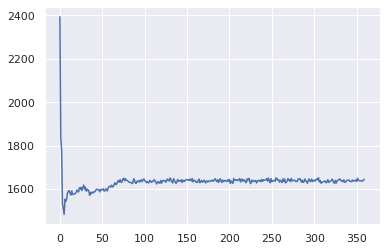

In [39]:
plt.plot(cv_grid_rmse)

In [40]:
feature_names

Index(['Unnamed: 0', 'alloc_key', 'iso3', 'BEDD-01-05-2010', 'BEDD-02-05-2010',
       'BEDD-03-05-2010', 'BEDD-04-05-2010', 'BEDD-05-05-2010',
       'BEDD-06-05-2010', 'BEDD-07-05-2010',
       ...
       'DTR-03-25-2005', 'DTR-04-25-2005', 'DTR-05-25-2005', 'DTR-06-25-2005',
       'DTR-07-25-2005', 'DTR-08-25-2005', 'DTR-09-25-2005', 'DTR-10-25-2005',
       'DTR-11-25-2005', 'DTR-12-25-2005'],
      dtype='object', length=363)